In [1]:
from ase.build import bulk
from atomistics.calculators import (
    calc_molecular_dynamics_phonons_with_lammpslib,
    evaluate_with_lammpslib,
    get_potential_by_name
)
from atomistics.workflows import (
    optimize_positions_and_volume,
    get_tasks_for_harmonic_approximation,
    analyse_results_for_harmonic_approximation,
)
from dynaphopy import Quasiparticle
import pandas
from phonopy.units import VaspToTHz
import spglib

from HelpfulFunctions import equilibriate_structure_at_finite_temperature



/cmmc/ptmp/pyironhb/mambaforge/envs/pyiron_mpie_cmti_2025-11-10/lib/python3.12/site-packages/atomistics/calculators/__init__.py:63: UserWarning: calc_static_with_qe(), evaluate_with_qe() and optimize_positions_and_volume_with_qe() are not available as the import of the module named 'pwtools' failed.
  raise_warning(module_list=quantum_espresso_function, import_error=e)


# Function Definitions

In [2]:
import ase
def create_vacancy(Structure:ase.Atoms,
                  index:int=0)->ase.Atoms:
    NewStructure = Structure.copy()
    del NewStructure[index]
    return NewStructure

In [3]:
import ase
import numpy as np

def insert_interstitial(Structure: ase.Atoms, 
                       position: np.ndarray = None,
                       element: str = None,
                       site_type: str = 'tetrahedral') -> ase.Atoms:
    from pyiron import ase_to_pyiron
    """
    Insert an interstitial atom into the structure.
    
    Parameters:
    -----------
    Structure : ase.Atoms
        The atomic structure
    position : np.ndarray, optional
        Cartesian coordinates for the interstitial. If None, uses site_type.
    element : str, optional
        Element symbol for interstitial. If None, uses same element as Structure[0]
    site_type : str, optional
        Type of interstitial site ('tetrahedral' or 'octahedral') for diamond/fcc structures.
        Only used if position is None.
    
    Returns:
    --------
    ase.Atoms
        Structure with interstitial added
    """
    
    if element is None:
        element = Structure[0].symbol
    
    if position is None:
        # For diamond cubic (like Si), calculate tetrahedral or octahedral site
        cell = Structure.cell.array
        
        if site_type == 'tetrahedral':
            # Tetrahedral site in diamond cubic: (1/4, 1/4, 1/4) in fractional coords
            position = 0.25 * (cell[0] + cell[1] + cell[2])
        elif site_type == 'octahedral':
            # Octahedral site: (1/2, 1/2, 1/2) in fractional coords
            position = 0.5 * (cell[0] + cell[1] + cell[2])
        else:
            raise ValueError("site_type must be 'tetrahedral' or 'octahedral'")
    
    # Add the interstitial atom
    interstitial = ase.Atom(element, position=position)
    NewStructure = Structure.copy()
    NewStructure.append(interstitial)
    
    return ase_to_pyiron(NewStructure)

In [4]:
import numpy as np
def GetPhononBands(Structure,
                  InteratomicPotential:str,
                    Temperature:int=0,
                   SuperCellDimensions:list[int] = [2,2,2],
                   band_path = None, #['GAMMA', 'X', 'U', 'K', 'GAMMA', 'L', 'W', 'X']
                  primitive_matrix=None):
    
    from ase.build import bulk
    from atomistics.calculators import (
        calc_molecular_dynamics_phonons_with_lammpslib,
        evaluate_with_lammpslib,
        get_potential_by_name
    )
    from atomistics.workflows import (
        optimize_positions_and_volume,
        get_tasks_for_harmonic_approximation,
        analyse_results_for_harmonic_approximation,
    )
    from dynaphopy import Quasiparticle
    import pandas
    from phonopy.units import VaspToTHz
    import spglib
    
    from HelpfulFunctions import equilibriate_structure_at_finite_temperature
    
    potential_dataframe = get_potential_by_name(potential_name="1988--Tersoff-J--Si-c--LAMMPS--ipr1"
                                               )
    if Temperature:
        structure_ase = equilibriate_structure_at_finite_temperature(
                                                                    structure=Structure,
                                                                    potential=potential_dataframe['Name'], 
                                                                    temperature=Temperature, 
                                                                    seed=4535,
                                                                    cell_scale_value=1
                                                                )
    else:
        task_dict = optimize_positions_and_volume(structure=Structure
                                                 )
        result_dict = evaluate_with_lammpslib(task_dict=task_dict,
                                              potential_dataframe=potential_dataframe
                                             )
        
        structure_ase = result_dict["structure_with_optimized_positions_and_volume"]

    cell = (
        structure_ase.cell.array,
        structure_ase.get_scaled_positions(),
        structure_ase.numbers,
    )
    if not primitive_matrix:
        primitive_matrix = spglib.standardize_cell(cell=cell, to_primitive=True)[
           0
        ] / structure_ase.get_volume() ** (1 / 3)
    
    task_dict, phonopy_obj = get_tasks_for_harmonic_approximation(
        structure=structure_ase,
        interaction_range=10,
        factor=VaspToTHz,
        displacement=0.01,
        primitive_matrix=primitive_matrix,
        number_of_snapshots=None,
    )
    result_dict = evaluate_with_lammpslib(
        task_dict=task_dict,
        potential_dataframe=potential_dataframe,
    )
    phonopy_dict = analyse_results_for_harmonic_approximation(
        phonopy=phonopy_obj,
        output_dict=result_dict,
        dos_mesh=20,
        number_of_snapshots=None,
    )
    if not Temperature:
        Temperature = 300 # Previously 600 K

    trajectory = calc_molecular_dynamics_phonons_with_lammpslib(
                                                                structure_ase=structure_ase,
                                                                potential_dataframe=potential_dataframe,
                                                                force_constants=phonopy_obj.force_constants,
                                                                phonopy_unitcell=phonopy_obj.unitcell,
                                                                phonopy_primitive_matrix=phonopy_obj.primitive_matrix,
                                                                phonopy_supercell_matrix=phonopy_obj.supercell_matrix,
                                                                total_time=2,  # ps
                                                                time_step=0.001,  # ps
                                                                relaxation_time=5,  # ps
                                                                silent=True,
                                                                supercell=SuperCellDimensions,
                                                                memmap=False,
                                                                velocity_only=True,
                                                                temperature=Temperature,
                                                            )

    Q_vectors = {
                'GAMMA':[0.0, 0.0, 0.0],
                'X':[0.5, 0.0, 0.5],
                'U':[0.625, 0.25, 0.625],
                'K':[0.375, 0.375, 0.75],
                'L':[0.5, 0.5, 0.5],
                'W':[0.5, 0.25, 0.75],
                'R':[0.5,0.0,0.0]
                }

    
    calculation = Quasiparticle(trajectory)
    
    # if band_path:
    #     calculation.set_band_ranges([ [Q_vectors.get(band_path[0]), Q_vectors.get(band_path[1])],
    #                               [Q_vectors.get(band_path[1]), Q_vectors.get(band_path[2])],
    #                               [Q_vectors.get(band_path[2]), Q_vectors.get(band_path[3])],
    #                               [Q_vectors.get(band_path[3]), Q_vectors.get(band_path[4])],
    #                               [Q_vectors.get(band_path[4]), Q_vectors.get(band_path[5])],
    #                               [Q_vectors.get(band_path[5]), Q_vectors.get(6)]
    #                             ])
        ## Needs work with the labels
    
    calculation.select_power_spectra_algorithm(2)  # select FFT algorithm
    calculation.get_renormalized_phonon_dispersion_bands()
    renormalized_force_constants = (
        calculation.get_renormalized_force_constants().get_array()
    )
    #renormalized_force_constants
    
    #calculation.plot_renormalized_phonon_dispersion_bands()

    return trajectory, calculation, phonopy_dict, phonopy_obj

# Unit Cell

In [5]:
structure_bulk = bulk("Si", cubic=True)
potential_name="1988--Tersoff-J--Si-c--LAMMPS--ipr1"

In [6]:
trajectory, calculation, phonopy_dict, phonopy_obj = GetPhononBands(Structure=structure_bulk, InteratomicPotential=potential_name)

Using 2000 steps
Using Fast Fourier transform (Numpy) function
set frequency range: 0.0 - 21.200000000000003

Q-point: 1 / 32     [ 0.00000  0.00000  0.00000 ]
Harmonic frequencies (THz):
[-4.13530665e-06 -4.13310396e-06 -4.12861117e-06  1.60678991e+01
  1.60678991e+01  1.60678991e+01]
Calculating phonon projection power spectra
Projecting into phonon mode
Projecting into wave vector
MD cell size relation: [2 2 2]
Power spectrum resolution requested unavailable, using maximum:  0.500000 THz
If you need higher resolution increase the number of data
FFT: [##############################] 100.00% Done...

Peak # 1
----------------------------------------------
Width                             0.495476 THz
Position                          0.031653 THz
Area (<K>)    (Lorentzian)        0.000000 eV
Area (<K>)    (Total)             0.000000 eV
<|dQ/dt|^2>                       0.000000 eV
Occupation number                -0.500000
Fit temperature                        nan K
Base line      

In [8]:
structure_vacancy = create_vacancy(Structure=structure_bulk)

In [9]:
trajectory_vacancy, calculation_vacancy, phonopy_dict_vacancy, phonopy_obj_vacancy = GetPhononBands(Structure=structure_vacancy, InteratomicPotential=potential_name)

Using 2000 steps
Using Fast Fourier transform (Numpy) function
set frequency range: 0.0 - 21.400000000000002

Q-point: 1 / 8     [ 0.00000  0.00000  0.00000 ]
Harmonic frequencies (THz):
[-3.63711978e-04 -3.63711835e-04 -3.63711746e-04  5.24331665e+00
  5.24331665e+00  5.24331665e+00  6.44993422e+00  6.44993422e+00
  6.44993422e+00  7.61398888e+00  1.18901824e+01  1.18901824e+01
  1.26631241e+01  1.26631241e+01  1.26631241e+01  1.50172267e+01
  1.50172267e+01  1.50172267e+01  1.61885967e+01  1.61885967e+01
  1.61885967e+01]
Calculating phonon projection power spectra
Projecting into phonon mode
Projecting into wave vector
MD cell size relation: [2 2 2]
Power spectrum resolution requested unavailable, using maximum:  0.500000 THz
If you need higher resolution increase the number of data
FFT: [##############################] 100.00% Done...

Peak # 1
----------------------------------------------
Width                             0.745860 THz
Position                          5.118243 TH

In [20]:
structure_interstitial = insert_interstitial(structure_bulk, site_type='octahedral')

In [22]:
trajectory_interstitial, calculation_interstitial, phonopy_dict_interstitial, phonopy_obj_interstitial = GetPhononBands(Structure=structure_interstitial, InteratomicPotential=potential_name)

Using 2000 steps
Using Fast Fourier transform (Numpy) function
set frequency range: 0.0 - 40.45

Q-point: 1 / 8     [ 0.00000  0.00000  0.00000 ]
Harmonic frequencies (THz):
[-1.00491713e-02 -1.00491713e-02 -1.00491713e-02  5.35975927e+00
  5.35975927e+00  5.35975927e+00  6.45369754e+00  6.45369754e+00
  6.45369754e+00  7.55807502e+00  7.55807502e+00  7.55807502e+00
  9.11013903e+00  9.11013903e+00  9.48918300e+00  9.48918300e+00
  9.48918300e+00  9.79022949e+00  9.79022949e+00  9.79022949e+00
  1.02546981e+01  1.18739142e+01  1.18739142e+01  1.18739142e+01
  3.06690063e+01  3.06690063e+01  3.06690063e+01]
Calculating phonon projection power spectra
Projecting into phonon mode
Projecting into wave vector
MD cell size relation: [2 2 2]
Power spectrum resolution requested unavailable, using maximum:  0.500000 THz
If you need higher resolution increase the number of data
FFT: [##############################] 100.00% Done...

Peak # 1
----------------------------------------------
Width   

## Ground state - 0K

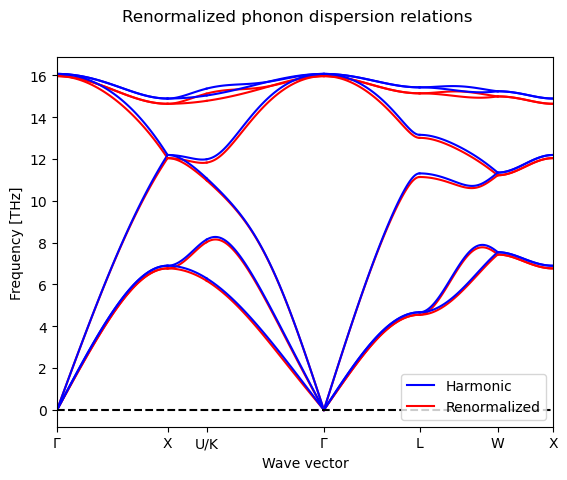

In [7]:
calculation.plot_renormalized_phonon_dispersion_bands()

## Vacancy ~ 12% 0K

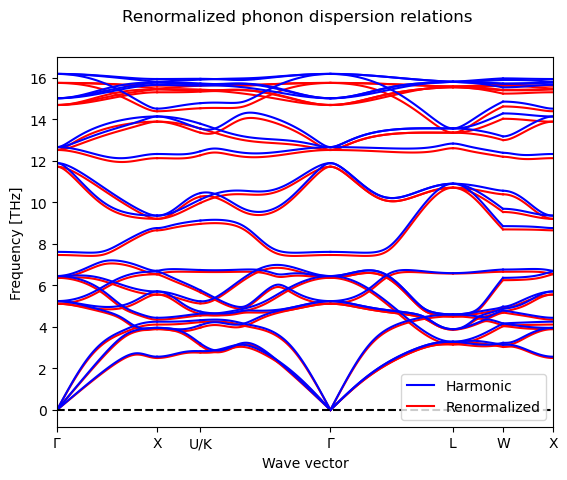

In [10]:
calculation_vacancy.plot_renormalized_phonon_dispersion_bands()

## Interstitial ~11% 0K

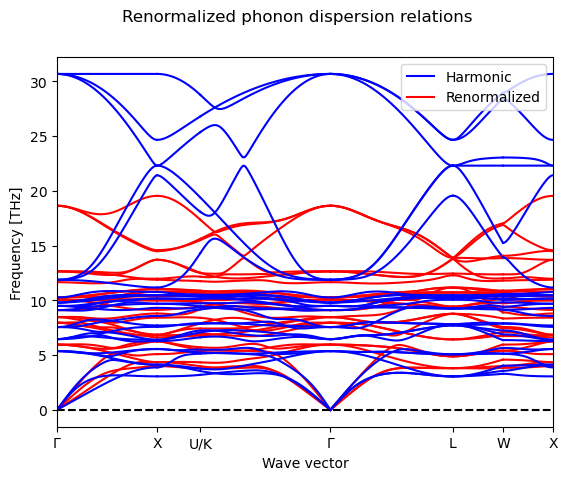

In [23]:
calculation_interstitial.plot_renormalized_phonon_dispersion_bands()

## Vacancy ~12% 300K

In [11]:
trajectory_vacancy_300, calculation_vacancy_300, phonopy_dict_vacancy_300, phonopy_obj_vacancy_300 = GetPhononBands(Structure=structure_vacancy, InteratomicPotential=potential_name, Temperature=300)

Using 2000 steps
Using Fast Fourier transform (Numpy) function
set frequency range: 0.0 - 22.700000000000003

Q-point: 1 / 8     [ 0.00000  0.00000  0.00000 ]
Harmonic frequencies (THz):
[-2.58657885e-04 -2.07316611e-04 -1.89479434e-04  4.80782555e+00
  4.99590762e+00  5.29067602e+00  6.30583068e+00  6.39718463e+00
  6.43583290e+00  7.46778663e+00  1.14794143e+01  1.16340446e+01
  1.21425608e+01  1.25021784e+01  1.27728984e+01  1.42978515e+01
  1.45031250e+01  1.52916523e+01  1.60679620e+01  1.65234559e+01
  1.72067952e+01]
Calculating phonon projection power spectra
Projecting into phonon mode
Projecting into wave vector
MD cell size relation: [2 2 2]
Power spectrum resolution requested unavailable, using maximum:  0.500000 THz
If you need higher resolution increase the number of data
FFT: [##############################] 100.00% Done...

Peak # 1
----------------------------------------------
Width                             0.467658 THz
Position                          0.033414 TH

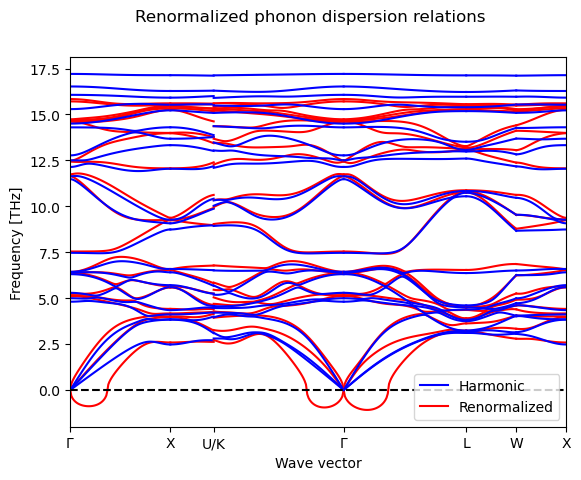

In [12]:
calculation_vacancy_300.plot_renormalized_phonon_dispersion_bands()

## Interstitial ~11% 300K

In [24]:
trajectory_interstitial_300, calculation_interstitial_300, phonopy_dict_interstitial_300, phonopy_obj_interstitial_300 = GetPhononBands(Structure=structure_interstitial, InteratomicPotential=potential_name, Temperature=300)

Using 2000 steps
Using Fast Fourier transform (Numpy) function
set frequency range: 0.0 - 38.85

Q-point: 1 / 8     [ 0.00000  0.00000  0.00000 ]
Harmonic frequencies (THz):
[-2.35282341e-03 -1.99945646e-03 -5.39224285e-04  4.83839722e+00
  5.23220112e+00  5.59245219e+00  5.69827276e+00  6.21319436e+00
  6.60762241e+00  7.24232615e+00  7.48119196e+00  7.88022683e+00
  8.51042518e+00  8.73158701e+00  9.25817949e+00  9.83860272e+00
  1.00707338e+01  1.06155737e+01  1.12990280e+01  1.17404140e+01
  1.33142767e+01  1.36661819e+01  1.46969535e+01  1.57524217e+01
  1.59573260e+01  2.51919106e+01  2.94083313e+01]
Calculating phonon projection power spectra
Projecting into phonon mode
Projecting into wave vector
MD cell size relation: [2 2 2]
Power spectrum resolution requested unavailable, using maximum:  0.500000 THz
If you need higher resolution increase the number of data
FFT: [##############################] 100.00% Done...

Peak # 1
----------------------------------------------
Width   

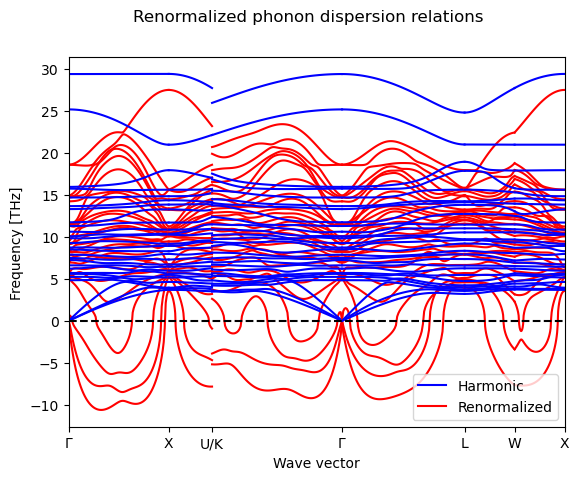

In [25]:
calculation_interstitial_300.plot_renormalized_phonon_dispersion_bands()

# Supercell 2x2x2

In [28]:
from pyiron import ase_to_pyiron
structure_bulk222 = ase_to_pyiron(bulk("Si", cubic=True)).repeat([2,2,2])
potential_name="1988--Tersoff-J--Si-c--LAMMPS--ipr1"

In [29]:
structure_bulk222_vacancy = create_vacancy(structure_bulk222)

In [30]:
trajectory_bulk222, calculation__bulk222, phonopy_dict_bulk222, phonopy_obj__bulk222 = GetPhononBands(Structure=structure_bulk222, InteratomicPotential=potential_name)
trajectory_bulk222_vacancy, calculation__bulk222_vacancy, phonopy_dict_bulk222_vacancy, phonopy_obj__bulk222_vacancy = GetPhononBands(Structure=structure_bulk222_vacancy, InteratomicPotential=potential_name)

Using 2000 steps
Using Fast Fourier transform (Numpy) function
set frequency range: 0.0 - 21.200000000000003

Q-point: 1 / 32     [ 0.00000  0.00000  0.00000 ]
Harmonic frequencies (THz):
[2.63390049e-06 2.65608834e-06 2.65775154e-06 1.60678991e+01
 1.60678991e+01 1.60678991e+01]
Calculating phonon projection power spectra
Projecting into phonon mode
Projecting into wave vector
MD cell size relation: [2 2 2]
Power spectrum resolution requested unavailable, using maximum:  0.500000 THz
If you need higher resolution increase the number of data
FFT: [##############################] 100.00% Done...

Peak # 1
----------------------------------------------
Width                             0.476520 THz
Position                          0.032113 THz
Area (<K>)    (Lorentzian)        0.000000 eV
Area (<K>)    (Total)             0.000000 eV
<|dQ/dt|^2>                       0.000000 eV
Occupation number                -0.500000
Fit temperature                        nan K
Base line            

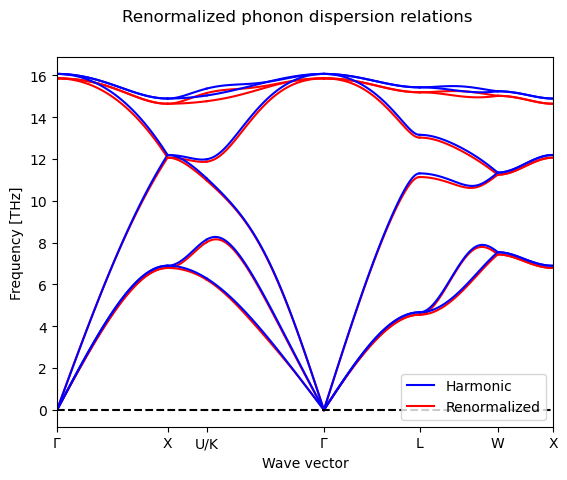

In [31]:
calculation__bulk222.plot_renormalized_phonon_dispersion_bands()

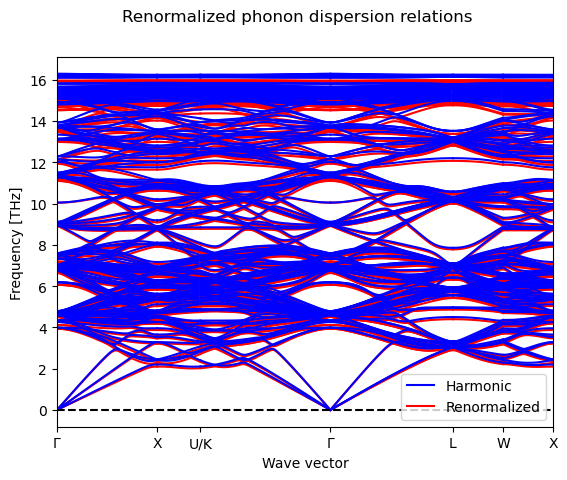

In [32]:
calculation__bulk222_vacancy.plot_renormalized_phonon_dispersion_bands()